In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics,cluster 
from umap import UMAP
import multiscale_phate as mp

import scanpy as sc
import scprep

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
adata = sc.read_h5ad('Ximerakis.h5ad')
adata

AnnData object with n_obs × n_vars = 37069 × 14699
    obs: 'cell_type1', 'donor_age', 'sample', 'organism', 'dataset_name', 'platform', 'organ', 'data_type', 'cell_ontology_class', 'cell_ontology_id', 'n_genes', 'n_counts', '__libsize__'
    var: 'variable_genes'
    uns: 'cell_ontology_class_colors', 'cell_type1_colors', 'data_quality', 'donor_age_colors', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_umap', 'latent'
    obsp: 'connectivities', 'distances'

In [4]:
data_group = adata.obs['cell_ontology_class']
n_groups = 18
set(data_group)

{' dendritic cell',
 'astrocyte',
 'choroid plexus epithelial cell',
 'endothelial cell',
 'ependymal cell',
 'macrophage',
 'microglial cell',
 'monocyte',
 'nan',
 'neuroendocrine cell',
 'neuron',
 'neuronal stem cell',
 'neutrophil',
 'oligodendrocyte',
 'oligodendrocyte precursor cell',
 'pericyte cell',
 'tanycyte',
 'vascular associated smooth muscle cell'}

C:\Anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


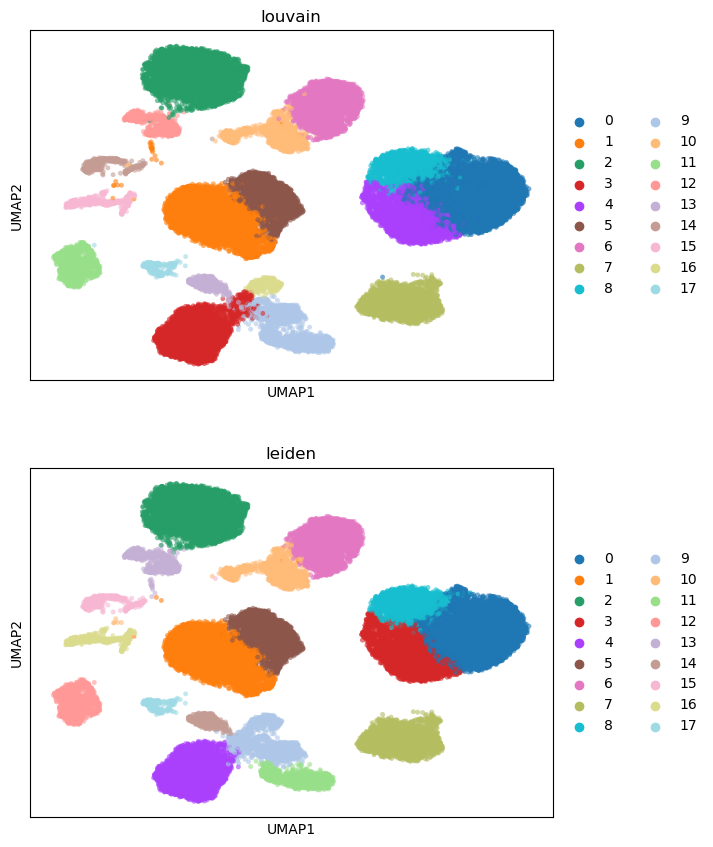

leiden: 0.6248833758840926 0.8126323445597794
louvain: 0.6311470297749777 0.8159960464369731


In [15]:
# sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.5, use_weights=True)
sc.tl.louvain(adata,resolution=0.5, use_weights=True)
sc.pl.umap(adata, color=['louvain', 'leiden'], s=50, alpha=0.6, ncols=1)

leiden_group = np.array(adata.obs['leiden'].values).astype('int')
ari_leiden = metrics.adjusted_rand_score(leiden_group, data_group)
ami_leiden = metrics.adjusted_mutual_info_score(leiden_group, data_group)

louvain_group = np.array(adata.obs['louvain'].values).astype('int')
ari_louvain = metrics.adjusted_rand_score(louvain_group, data_group)
ami_louvain = metrics.adjusted_mutual_info_score(louvain_group, data_group)

print("leiden:",ari_leiden,ami_leiden)
print("louvain:",ari_louvain,ami_louvain)

In [27]:
from dtne import *

In [28]:
X = adata.obsm['latent']

In [29]:
embedding = DTNE(k_neighbors = 20) 
Y = embedding.fit_transform(X)
dtne_cluster = embedding.cluster_cells(n_clusters=n_groups)

ari_dtne = metrics.adjusted_rand_score(dtne_cluster, data_group)
ami_dtne = metrics.adjusted_mutual_info_score(dtne_cluster, data_group)
print("dtne:",ari_dtne,ami_dtne)

dtne: 0.9290936787544459 0.8917131726293331


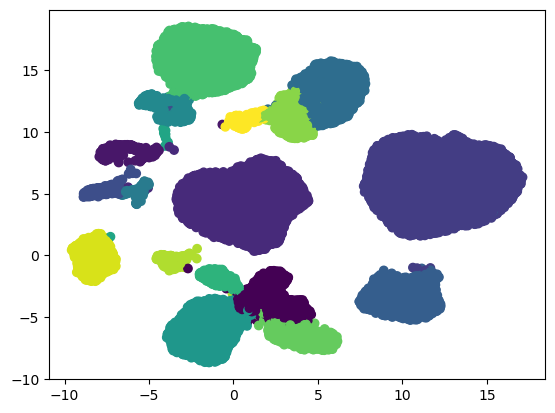

In [30]:
plt.scatter(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],c=dtne_cluster)

In [20]:
agglo_instance = cluster.AgglomerativeClustering(n_clusters=n_groups).fit(X)
agglo_groups = agglo_instance.labels_
ari_agglo = metrics.adjusted_rand_score(agglo_groups, data_group)
ami_agglo = metrics.adjusted_mutual_info_score(agglo_groups, data_group)

print("hierarchical:",ari_agglo,ami_agglo)

hierarchical: 0.5969975858657937 0.7970843684579281


In [31]:
X.shape

(37069, 10)

In [32]:
mp_op = mp.Multiscale_PHATE(random_state=0,n_pca=10,n_jobs=-2)
levels = mp_op.fit(X)
levels

Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculating diffusion potential...
  Calculated diffusion potential in 19.65 seconds.
  Setting epsilon to 4.4111
  Setting merge threshold to 0.5025
  Calculating condensation...
  Calculated condensation in 177.44 seconds.
Calculated Multiscale PHATE tree in 211.42 seconds.
Computing gradient...
Identifying salient levels of resolution...


[0, 12, 15, 44, 63, 79, 94, 100, 113, 118, 123, 131, 146]

In [52]:
tree_clusters = mp_op.get_tree_clusters(113)

In [53]:
len(set(tree_clusters))

20

In [54]:
mp_embedding, mp_clusters, mp_sizes = mp_op.transform(visualization_level = 0,cluster_level = 113)

In [55]:
ari_mp = metrics.adjusted_rand_score(mp_clusters, data_group)
ami_mp = metrics.adjusted_mutual_info_score(mp_clusters, data_group)
print("Multiscale PHATE:",ari_mp,ami_mp)

Multiscale PHATE: 0.9100738911031647 0.877802078825509


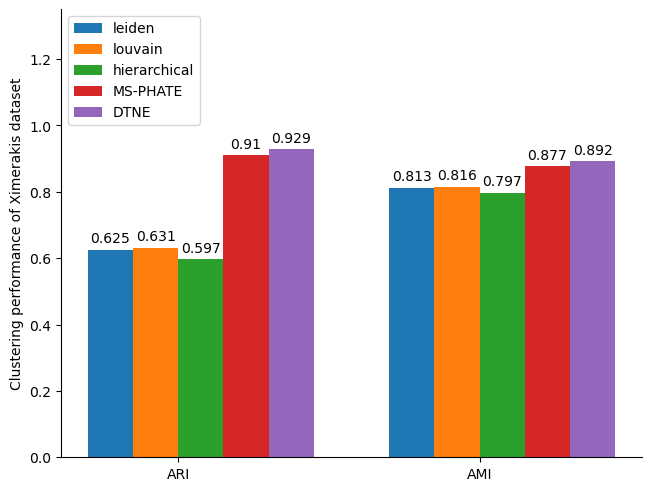

In [43]:
correlation = ['ARI','AMI']
pseudotime_corr = {
    'leiden':(0.625, 0.813),
    'louvain':(0.631, 0.816),
    'hierarchical':(0.597, 0.797),
    'MS-PHATE':(0.910, 0.877),
    'DTNE':(0.929, 0.892)
    }

x = np.arange(len(correlation))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for name, corr in pseudotime_corr.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, corr, width, label=name)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Clustering performance of Ximerakis dataset')
ax.set_xticks(x + 1.5*width, correlation)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, 1.35)

sns.despine(top=True,right=True,left=False,bottom=False,)
# ax.grid(False)
# ax.tick_params(bottom=True, left=True)

plt.savefig('./Ximerakis_plot.png', format='png', dpi=1000)
plt.savefig('./Ximerakis_plot.pdf', format='pdf', dpi=1000)